In [1]:
import sys
# sys.path.append("./packages")
# sys.path.append("./packages/neurolytics")
# sys.path.append("./packages/blip_analysis")
# sys.path.append("/camp/home/tootoos/working/tootoos/git/label_axes")

import numpy as np
import matplotlib.pyplot as plt
import blip_analysis as ba
import numpy as np
from scipy.stats import ttest_ind
import pickle
from matplotlib.gridspec import GridSpec
from sklearn.metrics import confusion_matrix
import matplotlib
from label_axes import label_axes
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

b


In [2]:
def plot_difference_distributions(ax, conc_models, onset_models, color=['r', 'b']):
    ''' Plot the difference in test scores between the two models for each cell.
    not being used now but needed for the sorted arg in the next function'''
    conc_test_scores = np.array([i.test_scores.mean(axis=-1) for i in conc_models])
    onset_test_scores = np.array([i.test_scores.mean(axis=-1) for i in onset_models])
    diffs = np.array(conc_test_scores - onset_test_scores)
    sorted_arg = np.argsort(diffs.mean(axis=-1))
    ax.errorbar(range(130), diffs.mean(axis=-1)[sorted_arg], yerr=diffs.std(axis=-1)[sorted_arg], fmt='.', color='k',  markersize=0, elinewidth=0.5)
    conc_best, onset_best, colors = find_best_fits(conc_models, onset_models, colors_base=color+['gray'])
    ax.scatter(range(130), diffs.mean(axis=-1)[sorted_arg], c=np.array(colors)[sorted_arg], s=3, zorder=10)
    print(len(conc_best), len(onset_best))
    return sorted_arg

def find_best_fits(conc_models, onset_models, colors_base=['r', 'b', 'gray']):
    ''' Find the cells that are significantly better fit by the conc model or the onset model.'''
    ttests = []
    ttests_conc = []
    ttests_onset = []
    colors = []
    conc_scores = np.array([i.test_scores.mean(axis=-1) for i in conc_models])
    onset_scores = np.array([i.test_scores.mean(axis=-1) for i in onset_models])
    
    for i in range(130):
        ttest = ttest_ind(conc_scores[i], onset_scores[i], equal_var=False)[1]*130
        ttests.append(ttest)
        if ttest < 0.05 and np.mean(conc_scores[i]) < np.mean(onset_scores[i]):
            ttests_conc.append(i)
            colors.append(colors_base[0])
        elif ttest < 0.05 and np.mean(conc_scores[i]) > np.mean(onset_scores[i]):
            ttests_onset.append(i)
            colors.append(colors_base[1])
        else:
            colors.append(colors_base[2])
    return ttests_conc, ttests_onset, colors

def plot_split_models_response(ax1, ax2, model1, model2, isi=1, colors=None, fontsize=8, legend=True, labels=None):
    ''' Plot the response of two models to the same cell used in part B and C of the figure.'''
    if colors is None:
        colors = ['k', 'C0', 'C1']
    ax1.errorbar(np.arange(0, 32*isi, isi), model1.X_test_avg.mean(axis=0), yerr=(model1.X_test_avg.mean(axis=0) - model1.X_test_avg.min(axis=0), model1.X_test_avg.max(axis=0) - model1.X_test_avg.mean(axis=0)),fmt='.', color=colors[0],  markersize=0, elinewidth=0.5)
    ax1.scatter(np.arange(0, 32*isi, isi), model1.X_test_avg.mean(axis=0), color=colors[0], s=3, zorder=10)
    ax1.errorbar(np.arange(0, 32*isi, isi), model1.pred_test_avg.mean(axis=0), yerr=(model1.pred_test_avg.mean(axis=0) - model1.pred_test_avg.min(axis=0), model1.pred_test_avg.max(axis=0) - model1.pred_test_avg.mean(axis=0)), fmt='.', color=colors[1],  markersize=0, elinewidth=0.5)
    ax1.scatter(np.arange(0, 32*isi, isi), model1.pred_test_avg.mean(axis=0), color=colors[1], s=3, zorder=10)

    ax2.errorbar(np.arange(0, 32*isi, isi), model2.X_test_avg.mean(axis=0), yerr=(model2.X_test_avg.mean(axis=0) - model2.X_test_avg.min(axis=0), model2.X_test_avg.max(axis=0) - model2.X_test_avg.mean(axis=0)),fmt='.', color=colors[0],  markersize=0, elinewidth=0.5)
    ax2.scatter(np.arange(0, 32*isi, isi), model2.X_test_avg.mean(axis=0), color=colors[0], s=3, zorder=10)
    ax2.errorbar(np.arange(0, 32*isi, isi), model2.pred_test_avg.mean(axis=0), yerr=(model2.pred_test_avg.mean(axis=0) - model2.pred_test_avg.min(axis=0), model2.pred_test_avg.max(axis=0) - model2.pred_test_avg.mean(axis=0)), fmt='.', color=colors[2],  markersize=0, elinewidth=0.5)
    ax2.scatter(np.arange(0, 32*isi, isi), model2.pred_test_avg.mean(axis=0), color=colors[2], s=3, zorder=10)

    x_ticks = np.arange(0, 32*isi, isi)
    ax1.set_xticks(x_ticks);
    ax1.set_xticklabels(glyphs, rotation=90, fontsize=fontsize);
    ax2.set_xticks(x_ticks);
    ax2.set_xticklabels(glyphs, rotation=90, fontsize=fontsize);
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.set_yticklabels([])
    [ax2.scatter([], [], color=colors[i], s=3, label=labels[i]) for i in range(len(colors))]
    
    if legend:
        ax2.legend()


def plot_best_cm(ax, cms, true_cm, fontsize=8, show_xticks=True, show_yticks=True, colorbar=True):
    ''' Plot the confusion matrix with the highest correlation to the true matrix'''
    best_idx = np.argmax([np.corrcoef(i.flatten(), true_cm.flatten())[0, 1] for i in cms])
    print(best_idx)
    
    im = ax.imshow(cms[best_idx], cmap='plasma', vmin=0)
    
    ax.set_xticks(range(32))
    ax.set_yticks(range(32))
    if show_xticks:
        ax.set_xticklabels(glyphs, rotation=90, fontsize=fontsize)
    else:
        ax.set_xticklabels([])
    if show_yticks:
        ax.set_yticklabels(glyphs, fontsize=fontsize)
    else:
        ax.set_yticklabels([])
    ax.set_ylim(31.5, -0.5)
    if colorbar:
        plt.colorbar(mappable=im, ax=ax)
    return im, np.max(cms[best_idx])

def plot_correlations(true_corrs, diff_corrs, conc_corrs, onset_corrs, joined_corrs, identiy, ax=None):
    ''' Plot the correlations between the true and predicted confusion matrices for the different models'''

    if ax is None:
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(111)
    
    odour_grays = ['k', 'gray', 'lightgray']
    ax.scatter(range(6), [true_corrs[0], diff_corrs[0], conc_corrs[0], onset_corrs[0], joined_corrs[0], identiy[0]], c=odour_grays[0], label='EB')
    ax.scatter(range(6), [true_corrs[1], diff_corrs[1], conc_corrs[1], onset_corrs[1], joined_corrs[1], identiy[1]], c=odour_grays[1], label='IA')
    ax.scatter(range(6), [true_corrs[2], diff_corrs[2], conc_corrs[2], onset_corrs[2], joined_corrs[2], identiy[2]], c=odour_grays[2], label='EA')

    ax.plot([0, 0], [np.min(true_corrs), np.max(true_corrs)], color='k', linestyle='--', zorder=-10)
    ax.plot([1, 1], [np.min(diff_corrs), np.max(diff_corrs)], color='k', linestyle='--', zorder=-10)
    ax.plot([2, 2], [np.min(conc_corrs), np.max(conc_corrs)], color='k', linestyle='--', zorder=-10)
    ax.plot([3, 3], [np.min(onset_corrs), np.max(onset_corrs)], color='k', linestyle='--', zorder=-10)
    ax.plot([4, 4], [np.min(joined_corrs), np.max(joined_corrs)], color='k', linestyle='--', zorder=-10)
    ax.plot([5, 5], [np.min(identiy), np.max(identiy)], color='k', linestyle='--', zorder=-10)

    ax.legend()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks(range(6))
    ax.set_xticklabels(['True odour', 'Diff', 'Conc', 'Onset', 'CAO', 'Identity'])
    ax.set_ylabel('Correlation coefficient')

In [3]:
glyphs = ba.get_glyphs()
conc_models1 = pickle.Unpickler(open('Data/230320_conc_models1.pkl', 'rb')).load()
conc_models2 = pickle.Unpickler(open('Data/230320_conc_models2.pkl', 'rb')).load()
conc_models3 = pickle.Unpickler(open('Data/230320_conc_models3.pkl', 'rb')).load()
onset_models1 = pickle.Unpickler(open('Data/230320_onset_models1.pkl', 'rb')).load()
onset_models2 = pickle.Unpickler(open('Data/230320_onset_models2.pkl', 'rb')).load()
onset_models3 = pickle.Unpickler(open('Data/230320_onset_models3.pkl', 'rb')).load()
cao_models1 = pickle.Unpickler(open('Data/230320_cao_models1.pkl', 'rb')).load()
cao_models2 = pickle.Unpickler(open('Data/230320_cao_models2.pkl', 'rb')).load()
cao_models3 = pickle.Unpickler(open('Data/230320_cao_models3.pkl', 'rb')).load()
diff_models1 = pickle.Unpickler(open('Data/230320_diff_models1.pkl', 'rb')).load()
diff_models2 = pickle.Unpickler(open('Data/230320_diff_models2.pkl', 'rb')).load()
diff_models3 = pickle.Unpickler(open('Data/230320_diff_models3.pkl', 'rb')).load()
base_models1 = pickle.Unpickler(open('Data/230320_base_models1.pkl', 'rb')).load()
base_models2 = pickle.Unpickler(open('Data/230320_base_models2.pkl', 'rb')).load()
base_models3 = pickle.Unpickler(open('Data/230320_base_models3.pkl', 'rb')).load()

In [4]:
conc_test_scores1 = np.array([i.test_scores.mean(axis=-1) for i in conc_models1])
conc_test_scores2 = np.array([i.test_scores.mean(axis=-1) for i in conc_models2])
conc_test_scores3 = np.array([i.test_scores.mean(axis=-1) for i in conc_models3])
onset_test_scores1 = np.array([i.test_scores.mean(axis=-1) for i in onset_models1])
onset_test_scores2 = np.array([i.test_scores.mean(axis=-1) for i in onset_models2])
onset_test_scores3 = np.array([i.test_scores.mean(axis=-1) for i in onset_models3])

mean_conc_test_scores1 = conc_test_scores1.mean(axis=-1)
mean_conc_test_scores2 = conc_test_scores2.mean(axis=-1)
mean_conc_test_scores3 = conc_test_scores3.mean(axis=-1)
mean_onset_test_scores1 = onset_test_scores1.mean(axis=-1)
mean_onset_test_scores2 = onset_test_scores2.mean(axis=-1)
mean_onset_test_scores3 = onset_test_scores3.mean(axis=-1)


In [5]:
avg_diff1 = (conc_test_scores1 - onset_test_scores1).mean(axis=-1)
avg_diff2 = (conc_test_scores2 - onset_test_scores2).mean(axis=-1)
avg_diff3 = (conc_test_scores3 - onset_test_scores3).mean(axis=-1)

std_diffs1 = (conc_test_scores1 - onset_test_scores1).std(axis=-1)
std_diffs2 = (conc_test_scores2 - onset_test_scores2).std(axis=-1)
std_diffs3 = (conc_test_scores3 - onset_test_scores3).std(axis=-1)

In [6]:
data_joined = np.load('Data/230612_data_joined.npy')
#cms = [confusion_matrix(data[i, :, 1].reshape(-1), data[i, :, 0].reshape(-1), labels=range(32), normalize='true') for i in range(20)]
cms1 = [confusion_matrix(data_joined[0, i, :, 1].reshape(-1), data_joined[0, i, :, 0].reshape(-1), labels=range(32), normalize='true') for i in range(20)]
cms2 = [confusion_matrix(data_joined[1, i, :, 1].reshape(-1), data_joined[1, i, :, 0].reshape(-1), labels=range(32), normalize='true') for i in range(20)]
cms3 = [confusion_matrix(data_joined[2, i, :, 1].reshape(-1), data_joined[2, i, :, 0].reshape(-1), labels=range(32), normalize='true') for i in range(20)]
cms_conc1 = [confusion_matrix(data_joined[4, i, :, 1].reshape(-1), data_joined[4, i, :, 0].reshape(-1), labels=range(32), normalize='true') for i in range(20)]
cms_onset1 = [confusion_matrix(data_joined[3, i, :, 1].reshape(-1), data_joined[3, i, :, 0].reshape(-1), labels=range(32), normalize='true') for i in range(20)]
cms_joined1 = [confusion_matrix(data_joined[5, i, :, 1].reshape(-1), data_joined[5, i, :, 0].reshape(-1), labels=range(32), normalize='true') for i in range(20)]
cms_conc2 = [confusion_matrix(data_joined[6, i, :, 1].reshape(-1), data_joined[6, i, :, 0].reshape(-1), labels=range(32), normalize='true') for i in range(20)]
cms_onset2 = [confusion_matrix(data_joined[7, i, :, 1].reshape(-1), data_joined[7, i, :, 0].reshape(-1), labels=range(32), normalize='true') for i in range(20)]
cms_joined2 = [confusion_matrix(data_joined[8, i, :, 1].reshape(-1), data_joined[8, i, :, 0].reshape(-1), labels=range(32), normalize='true') for i in range(20)]
cms_conc3 = [confusion_matrix(data_joined[9, i, :, 1].reshape(-1), data_joined[9, i, :, 0].reshape(-1), labels=range(32), normalize='true') for i in range(20)]
cms_onset3 = [confusion_matrix(data_joined[10, i, :, 1].reshape(-1), data_joined[10, i, :, 0].reshape(-1), labels=range(32), normalize='true') for i in range(20)]
cms_joined3 = [confusion_matrix(data_joined[11, i, :, 1].reshape(-1), data_joined[11, i, :, 0].reshape(-1), labels=range(32), normalize='true') for i in range(20)]

In [7]:
true_classifiers = pickle.Unpickler(open('../Fig3/../Fig3/230315_full_classifier_RFs.pkl', 'rb')).load()
preds = true_classifiers[:, :, 1]
preds = np.array([np.hstack(i) for i in preds])
trues = [i for j in range(100) for i in range(32)]
cm_true1 = confusion_matrix(trues, preds[0], labels=range(32), normalize='true')
cm_true2 = confusion_matrix(trues, preds[1], labels=range(32), normalize='true')
cm_true3 = confusion_matrix(trues, preds[2], labels=range(32), normalize='true')


In [8]:
max_corrs = lambda cms, cm_true: np.max([np.corrcoef(i.flatten(), cm_true.flatten())[0, 1] for i in cms])
diff_corrs = [max_corrs(cms1, cm_true1), max_corrs(cms2, cm_true2), max_corrs(cms3, cm_true3)]
conc_corrs = [max_corrs(cms_conc1, cm_true1), max_corrs(cms_conc2, cm_true2), max_corrs(cms_conc3, cm_true3)]
onset_corrs = [max_corrs(cms_onset1, cm_true1), max_corrs(cms_onset2, cm_true2), max_corrs(cms_onset3, cm_true3)]
joined_corrs = [max_corrs(cms_joined1, cm_true1), max_corrs(cms_joined2, cm_true2), max_corrs(cms_joined3, cm_true3)]
true_corrs = np.triu(np.corrcoef([cm_true1.flatten(), cm_true2.flatten(), cm_true3.flatten()]), 1).flatten()
true_corrs = true_corrs[np.where(true_corrs != 0)]
identiy = [np.corrcoef([i.flatten(), np.identity(32).flatten()])[0, 1] for i in [cm_true1, cm_true2, cm_true3]]
print(identiy)

[0.489757277225493, 0.41008889630176826, 0.4357846050789411]


20 61
26 36
11
15
12
17
(0.0, None)


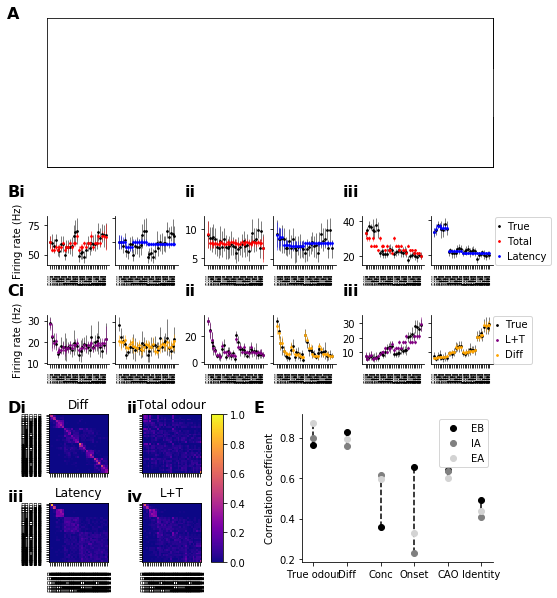

In [10]:
fig = plt.figure(figsize=(8, 10))
gs = GridSpec(6, 3, hspace=1, wspace=0.2, )
diff_ax1 = fig.add_subplot(gs[0, :])
diff_ax2 = fig.add_subplot(gs[1, :])
conc_vs_onset_args = plot_difference_distributions(diff_ax1, conc_models1, onset_models1)
cao_vs_diff_args = plot_difference_distributions(diff_ax2, cao_models1, diff_models1, color=['purple', 'orange'])
diff_ax1.set_xticks([])
diff_ax2.set_xticks([])
diff_ax1.set_yticks([])
diff_ax2.set_yticks([])

schem_ax = fig.add_subplot(gs[:2, :])
schem_ax.set_xticks([])
schem_ax.set_yticks([])


low_conc_model = conc_models1[conc_vs_onset_args[0]]
low_onset_model = onset_models1[conc_vs_onset_args[0]]
high_conc_model = conc_models1[conc_vs_onset_args[-1]]
high_onset_model = onset_models1[conc_vs_onset_args[-1]]
mid_conc_model = conc_models1[conc_vs_onset_args[65]]
mid_onset_model = onset_models1[conc_vs_onset_args[65]]
subgs1 = gs[2, 0].subgridspec(1, 2, wspace=0.1)
subgs2 = gs[2, 1].subgridspec(1, 2, wspace=0.1)
subgs3 = gs[2, 2].subgridspec(1, 2, wspace=0.1)

#sub_gs = gs[2:4, :].subgridspec(2, 6, wspace=0.5)

low_model_ax_cao1 = fig.add_subplot(subgs1[0])
low_model_ax_cao2 = fig.add_subplot(subgs1[1])
mid_model_ax_cao1 = fig.add_subplot(subgs2[0])
mid_model_ax_cao2 = fig.add_subplot(subgs2[1])
high_model_ax_cao1 = fig.add_subplot(subgs3[0])
high_model_ax_cao2 = fig.add_subplot(subgs3[1])

plot_split_models_response(low_model_ax_cao1, low_model_ax_cao2, low_conc_model, low_onset_model, isi=2, labels=['True','Total', 'Latency'], colors=['k', 'r', 'b'], legend=False)
plot_split_models_response(mid_model_ax_cao1, mid_model_ax_cao2, mid_conc_model, mid_onset_model, isi=2, colors=['k', 'r', 'b'], labels = ['True','Total', 'Latency'], legend=False)
plot_split_models_response(high_model_ax_cao1, high_model_ax_cao2, high_conc_model, high_onset_model, isi=2, labels=['True','Total', 'Latency'], colors=['k', 'r', 'b'], legend=False)
#plot_models_response(low_model_ax_cao, [low_conc_model, low_onset_model], isi=2, labels=['True', 'Conc', 'Onset'], colors=['k','r', 'b'], legend=False)
#plot_models_response(high_model_ax_cao, [high_conc_model, high_onset_model], isi=2, colors=['k','r', 'b'], labels=['True', 'Conc', 'Onset'])
#plot_models_response(mid_model_ax_cao, [mid_conc_model, mid_onset_model], isi=2, colors=['k','r', 'b'])
high_model_ax_cao2.legend(ncol=1, handlelength=0.0, bbox_to_anchor=(2, 0.5), loc='right')
low_model_ax_cao1.set_ylabel('Firing rate (Hz)')

[i.set_xticklabels(glyphs, fontsize=4) for i in [low_model_ax_cao1, low_model_ax_cao2, mid_model_ax_cao1, mid_model_ax_cao2, high_model_ax_cao1, high_model_ax_cao2]]

low_diff_model = diff_models1[cao_vs_diff_args[0]]
low_cao_model = cao_models1[cao_vs_diff_args[0]]
high_diff_model = diff_models1[cao_vs_diff_args[-1]]
high_cao_model = cao_models1[cao_vs_diff_args[-1]]
mid_diff_model = diff_models1[cao_vs_diff_args[65]]
mid_cao_model = cao_models1[cao_vs_diff_args[65]]

subgs1 = gs[3, 0].subgridspec(1, 2, wspace=0.1)
subgs2 = gs[3, 1].subgridspec(1, 2, wspace=0.1)
subgs3 = gs[3, 2].subgridspec(1, 2, wspace=0.1)


low_model_ax1 = fig.add_subplot(subgs1[0])
low_model_ax2 = fig.add_subplot(subgs1[1])
mid_model_ax1 = fig.add_subplot(subgs2[0])
mid_model_ax2 = fig.add_subplot(subgs2[1])
high_model_ax1 = fig.add_subplot(subgs3[0])
high_model_ax2 = fig.add_subplot(subgs3[1])
# low_model_ax = fig.add_subplot(gs[3, 0])
# mid_model_ax = fig.add_subplot(gs[3, 1])
# high_model_ax = fig.add_subplot(gs[3, 2])

# plot_models_response(low_model_ax, [low_cao_model, low_diff_model], isi=2, labels=['True', 'CAO', 'Diff'], colors=['k', 'purple','orange'], legend=False)
# plot_models_response(high_model_ax, [high_cao_model, high_diff_model], isi=2, colors=['k','purple','orange'], labels=['True', 'CAO', 'Diff'],)
# plot_models_response(mid_model_ax, [mid_cao_model, mid_diff_model], isi=2, colors=['k','purple','orange'])

plot_split_models_response(low_model_ax1, low_model_ax2, low_cao_model, low_diff_model, isi=2, labels=['True','L+T', 'Diff'], colors=['k', 'purple', 'orange'], legend=False)
plot_split_models_response(mid_model_ax1, mid_model_ax2, mid_cao_model, mid_diff_model, isi=2, colors=['k', 'purple', 'orange'], labels = ['True','L+T', 'Diff'], legend=False)
plot_split_models_response(high_model_ax1, high_model_ax2, high_cao_model, high_diff_model, isi=2, labels=['True','L+T', 'Diff'], colors=['k', 'purple', 'orange'], legend=False)

high_model_ax2.legend(ncol=1, handlelength=0.0, bbox_to_anchor=(1.7, 0.5), loc='right')
low_model_ax1.set_ylabel('Firing rate (Hz)')
[i.set_xticklabels(glyphs, fontsize=4) for i in [low_model_ax1, low_model_ax2, mid_model_ax1, mid_model_ax2, high_model_ax1, high_model_ax2]]


sub_gs = gs[-2:, :].subgridspec(2, 4, wspace=1, hspace=0.5)
cm_ax1 = fig.add_subplot(sub_gs[0, 0])
cm_ax2 = fig.add_subplot(sub_gs[0, 1])
cm_ax3 = fig.add_subplot(sub_gs[1, 0])
cm_ax4 = fig.add_subplot(sub_gs[1, 1])
corr_ax = fig.add_subplot(sub_gs[:, 2:])

im1, vmax1 = plot_best_cm(cm_ax1, cms1, cm_true1, show_xticks=False, colorbar=False)
im2, vmax2 = plot_best_cm(cm_ax2, cms_conc1, cm_true1, show_yticks=False, show_xticks=False, colorbar=False)
im3, vmax3 = plot_best_cm(cm_ax3, cms_onset1, cm_true1, show_yticks=True, colorbar=False)
im4, vmax4 = plot_best_cm(cm_ax4, cms_joined1, cm_true1, show_yticks=False, colorbar=False)
plot_correlations(true_corrs, diff_corrs, conc_corrs, onset_corrs, joined_corrs, identiy, ax=corr_ax)
print(im1.get_clim())
vmax = np.max([vmax1, vmax2, vmax3, vmax4])
[i.set_clim([0, vmax]) for i in [im1, im2, im3, im4]]
plt.draw()

# cm_ax1_pos = cm_ax1.get_position()
# cm_ax1.set_position([cm_ax1_pos.x0 + 0.05, cm_ax1_pos.y0, cm_ax1_pos.width, cm_ax1_pos.height])
# cm_ax3_pos = cm_ax3.get_position()
# cm_ax3.set_position([cm_ax3_pos.x0 + 0.05, cm_ax3_pos.y0, cm_ax3_pos.width, cm_ax3_pos.height])
cm_ax2_pos = cm_ax2.get_position()
cm_ax2.set_position([cm_ax2_pos.x0- 0.06, cm_ax2_pos.y0, cm_ax2_pos.width, cm_ax2_pos.height])
cm_ax4_pos = cm_ax4.get_position()
cm_ax4.set_position([cm_ax4_pos.x0- 0.06, cm_ax4_pos.y0, cm_ax4_pos.width, cm_ax4_pos.height])
cbar_ax = fig.add_axes([cm_ax2_pos.x0 + 0.06, cm_ax4_pos.y0, 0.02, 0.205])
plt.colorbar(im3, cax=cbar_ax)
cm_ax1.set_title('Diff')
cm_ax2.set_title('Total odour')
cm_ax3.set_title('Latency')
cm_ax4.set_title('L+T')
axes = [schem_ax, low_model_ax_cao1, mid_model_ax_cao1, high_model_ax_cao1, low_model_ax1, mid_model_ax1, high_model_ax1, cm_ax1, cm_ax2, cm_ax3, cm_ax4, corr_ax]
labels = ['A', 'Bi', 'ii', 'iii', 'Ci', 'ii', 'iii', 'Di', 'ii', 'iii', 'iv', 'E']
label_axes.label_axes(axes, labels, align_x=[[0, 1, 4, 7], [2, 5], [3, 6], [7, 9], [8, 10]], align_y= [[1, 2, 3], [4, 5, 6], [7, 8, 11], [9, 10]], fontweight='bold', fontsize=16, align_x_fun=np.min, align_y_fun=np.max, dx=[-0.01, -0.01, 0, 0, -0.01, 0, 0, -0.01, -0.015, -0.015, -0.02, -0.02], dy=[0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, -0.02, -0.02, -0.02, -0.02, -0.02])
#plt.savefig('230703_fig4.pdf', bbox_inches='tight')